In [2]:
import numpy as np
import pandas as pd
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import malaya
import random
import re
import string
from pprint import pprint
from statistics import mean
import pickle
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

sia = SentimentIntensityAnalyzer()
mly = malaya.sentiment.multinomial()

malay_stopwords = np.load('data/malay_stopwords.npy')
positive_malay_words = np.load('data/positive_malay_words.npy')
negative_malay_words = np.load('data/negative_malay_words.npy')

unwanted = nltk.corpus.stopwords.words("english")
unwanted.extend(malay_stopwords)

def skip_unwanted(pos_tuple):
    word, tag = pos_tuple
    if not word.isalpha() or word in unwanted:
        return False
    #if tag.startswith("NN"):
        #return False
    if word in string.punctuation:
        return False
    return True

df = pd.read_csv('datasets/duck_training.csv')
df = df.replace(-1, 'negative')
df = df.replace(0, 'neutral')
df = df.replace(1, 'positive')
df = df[df['TweetSentiment'] != 'neutral']

df2 = pd.read_csv('datasets/student_tweet_training.csv')

df3 = pd.read_csv('datasets/malay_dataset_twitter_training.csv')
df3 = df3[df3['TweetSentiment'] != 'neutral']

dfs = [df, df2, df3]
df = pd.concat(dfs, ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True) #shuffles the dataframe

tweets_df = df['TweetText']
positive_tweets = np.array(tweets_df[df['TweetSentiment'] == 'positive'])
negative_tweets = np.array(tweets_df[df['TweetSentiment'] == 'negative'])
tweets = np.concatenate((positive_tweets, negative_tweets))

positive_words = []
for positive_tweet in positive_tweets :
    #removes hyperlinks and twitter mentions
    positive_tweet = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','', positive_tweet)
    positive_tweet = re.sub('(@[A-Za-z0-9_]+)','', positive_tweet)

    positive_tweet = positive_tweet.lower()
    positive_words.extend(nltk.pos_tag(nltk.word_tokenize(positive_tweet)))

positive_words_raw = [word for word, tag in positive_words]

positive_words = [word for word, tag in filter(
    skip_unwanted,
    positive_words)
]

negative_words = []
for negative_tweet in negative_tweets :
    #removes hyperlinks and twitter mentions
    negative_tweet = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','', negative_tweet)
    negative_tweet = re.sub('(@[A-Za-z0-9_]+)','', negative_tweet)

    negative_tweet = negative_tweet.lower()
    negative_words.extend(nltk.pos_tag(nltk.word_tokenize(negative_tweet)))

negative_words_raw = [word for word, tag in negative_words]

negative_words = [word for word, tag in filter(
    skip_unwanted,
    negative_words)
]

learned_words = np.concatenate((positive_words, negative_words))
random.shuffle(learned_words)

positive_fd = nltk.FreqDist(positive_words)
negative_fd = nltk.FreqDist(negative_words)
common_set = set(positive_fd).intersection(negative_fd)

for word in common_set:
    del positive_fd[word]
    del negative_fd[word]
    learned_words = np.delete(learned_words, np.where(learned_words == word))
    
positive_word_top_100 = [word for word, count in positive_fd.most_common(100)]
negative_word_top_100 = [word for word, count in negative_fd.most_common(100)]

#positive_bigram_finder = nltk.collocations.BigramCollocationFinder.from_words([
    #word for word in positive_words_raw
    #if word.isalpha() and word not in unwanted
#])

#negative_bigram_finder = nltk.collocations.BigramCollocationFinder.from_words([
    #word for word in negative_words_raw
    #if word.isalpha() and word not in unwanted
#])

#np.save('data/positive_word_top_100', positive_word_top_100)
#np.save('data/negative_word_top_100', negative_word_top_100)
#np.save('data/learned_words', learned_words)

def get_features(tweet):
    features = dict()
    top_positive_words_frequency = 0
    top_negative_words_frequency = 0
    positive_malay_words_frequency = 0
    negative_malay_words_frequency = 0
    english_compound_scores = list()
    english_positive_scores = list()
    english_negative_scores = list()
    malaya_positive_scores = list()
    malaya_negative_scores = list()

    word_tokens = set(nltk.word_tokenize(tweet))

    for sentence in nltk.sent_tokenize(tweet):
        #removes hyperlinks and twitter mentions
        sentence = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','', sentence)
        sentence = re.sub('(@[A-Za-z0-9_]+)','', sentence)

        for word in nltk.word_tokenize(sentence):
            if word.lower() in positive_word_top_100:
                top_positive_words_frequency += 1
            if word.lower() in negative_word_top_100:
                top_negative_words_frequency += 1
            if word.lower() in positive_malay_words:
                positive_malay_words_frequency += 1
            if word.lower() in negative_malay_words:
                negative_malay_words_frequency += 1
        
        malaya_positive_scores.append(mly.predict_proba([sentence])[0]["positive"])
        malaya_negative_scores.append(mly.predict_proba([sentence])[0]["negative"])

        english_compound_scores.append(sia.polarity_scores(sentence)["compound"])
        english_positive_scores.append(sia.polarity_scores(sentence)["pos"])
        english_negative_scores.append(sia.polarity_scores(sentence)["neg"])

    features["malaya_mean_positive"] = mean(malaya_positive_scores)
    features["malaya_mean_negative"] = mean(malaya_negative_scores)
    
    features["english_mean_compound"] = mean(english_compound_scores) + 1
    features["english_mean_positive"] = mean(english_positive_scores)
    features["english_mean_negative"] = mean(english_negative_scores)
    
    features["top_positive_words_frequency"] = top_positive_words_frequency
    features["top_negative_words_frequency"] = top_negative_words_frequency

    features["positive_malay_words_frequency"] = positive_malay_words_frequency
    features["negative_malay_words_frequency"] = negative_malay_words_frequency

    for word in learned_words:
        if word in word_tokens:
            features[F"contains({word})"] = 1
        else:
            features[F"contains({word})"] = 0

    return features

training_dataset = [
    (get_features(tweet), "positive")
    for tweet in positive_tweets
]
training_dataset.extend([
    (get_features(tweet), "negative")
    for tweet in negative_tweets
])

training_count = len(training_dataset) // 5
random.shuffle(training_dataset)

classifiers = {
    "MultinomialNB": MultinomialNB(),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
    "LogisticRegression": LogisticRegression(),
    "MLPClassifier": MLPClassifier(max_iter=1000),
    "SVMClassifier": SVC(),
}

for classifier_name, sklearn_classifier in classifiers.items():
    classifier = nltk.classify.SklearnClassifier(sklearn_classifier)

    print(F"\nTraining {classifier_name} model...")
    print(F"Training sample size: {len(training_dataset)-training_count}")
    classifier.train(training_dataset[:len(training_dataset)-training_count])

    print(F"Testing {classifier_name} model...")
    print(F"Testing sample size: {training_count}")
    accuracy = nltk.classify.accuracy(classifier, training_dataset[len(training_dataset)-training_count:])

    print(F"{classifier_name} - Accuracy: {accuracy:.2%}")
    pickle.dump(classifier, open(F"models/{classifier_name}.pickle", 'wb'))


Training MultinomialNB model...
Training sample size: 1414
Testing MultinomialNB model...
Testing sample size: 353
MultinomialNB - Accuracy: 80.45%

Training KNeighborsClassifier model...
Training sample size: 1414
Testing KNeighborsClassifier model...
Testing sample size: 353
KNeighborsClassifier - Accuracy: 73.65%

Training DecisionTreeClassifier model...
Training sample size: 1414
Testing DecisionTreeClassifier model...
Testing sample size: 353
DecisionTreeClassifier - Accuracy: 75.35%

Training RandomForestClassifier model...
Training sample size: 1414
Testing RandomForestClassifier model...
Testing sample size: 353
RandomForestClassifier - Accuracy: 79.04%

Training LogisticRegression model...
Training sample size: 1414
Testing LogisticRegression model...
Testing sample size: 353
LogisticRegression - Accuracy: 81.02%

Training MLPClassifier model...
Training sample size: 1414
Testing MLPClassifier model...
Testing sample size: 353
MLPClassifier - Accuracy: 82.72%

Training SVMCla

Multinomial NB 

Training Accuracy scores: [0.93205945 0.9398443  0.93069307 0.92857143 0.92432815]
Mean Training Accuracy: 93.10992791726852
Training Precision scores: [0.9616     0.9637224  0.96753247 0.9569378  0.95948136]
Mean Training Precision: 0.9618548050956253
Training Recall scores: [0.89301634 0.90787519 0.884273   0.89020772 0.87833828]
Mean Training Recall: 0.8907421043117093
Training F1 scores: [0.92604006 0.93496557 0.92403101 0.92236741 0.91711851]
Mean Training F1 Score: 0.9249045123717039
Validation Accuracy scores: [0.80508475 0.78531073 0.78186969 0.85552408 0.82436261]
Mean Validation Accuracy: 81.0430370832733
Validation Precision scores: [0.84722222 0.88429752 0.79738562 0.92086331 0.86805556]
Mean Validation Precision: 0.8635648457412971
Validation Recall scores: [0.72189349 0.63313609 0.72619048 0.76190476 0.74404762]
Mean Validation Recall: 0.7174344885883348
Validation F1 scores: [0.77955272 0.73793103 0.76012461 0.83387622 0.80128205]
Mean Validation F1 Scor

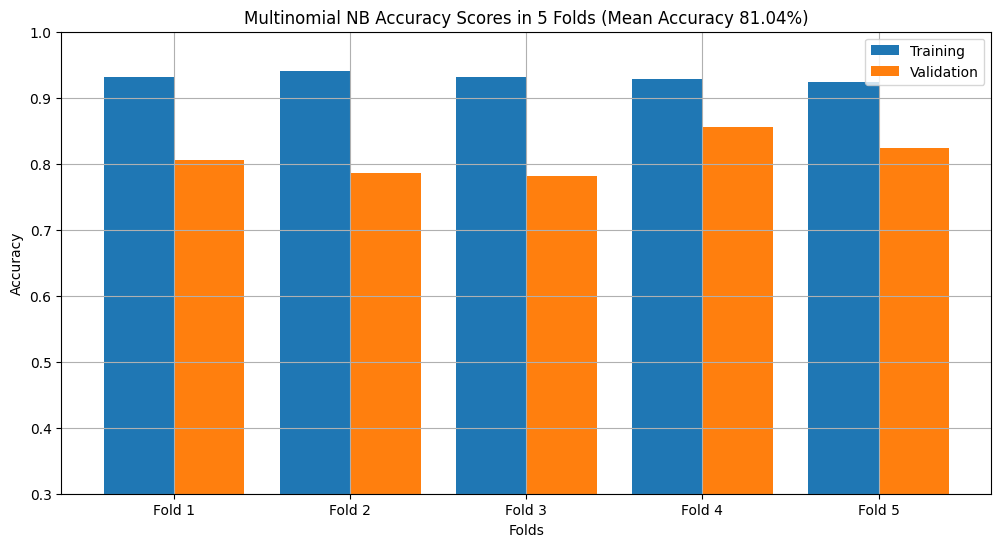

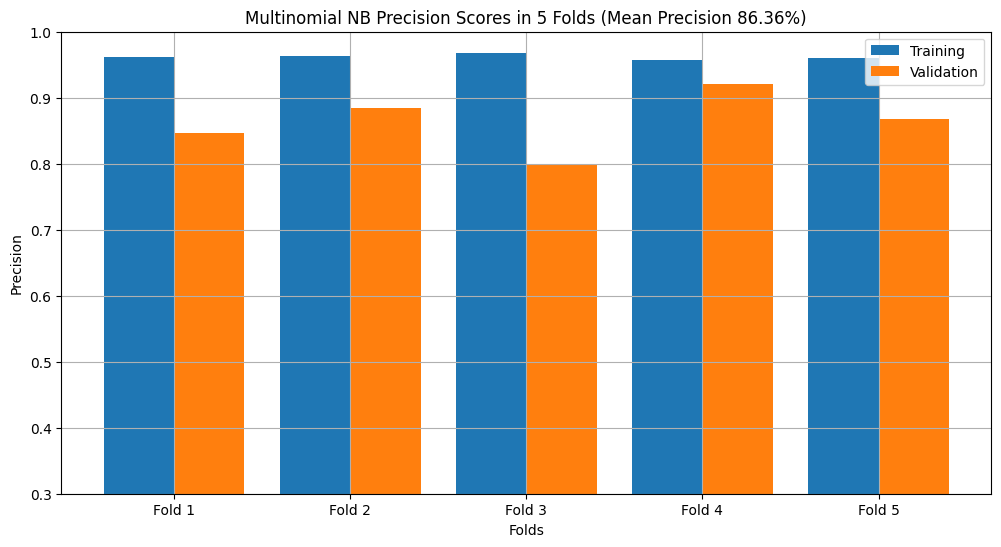

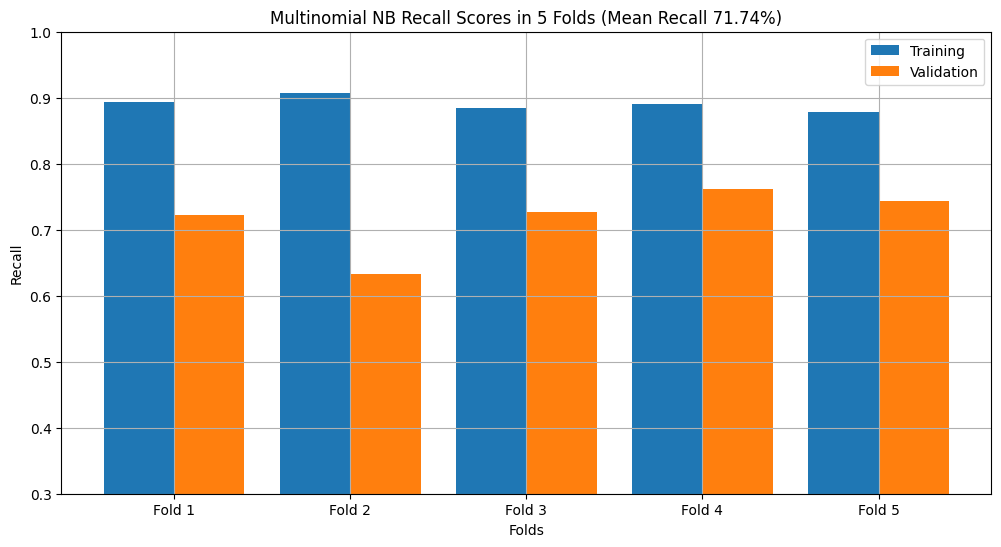

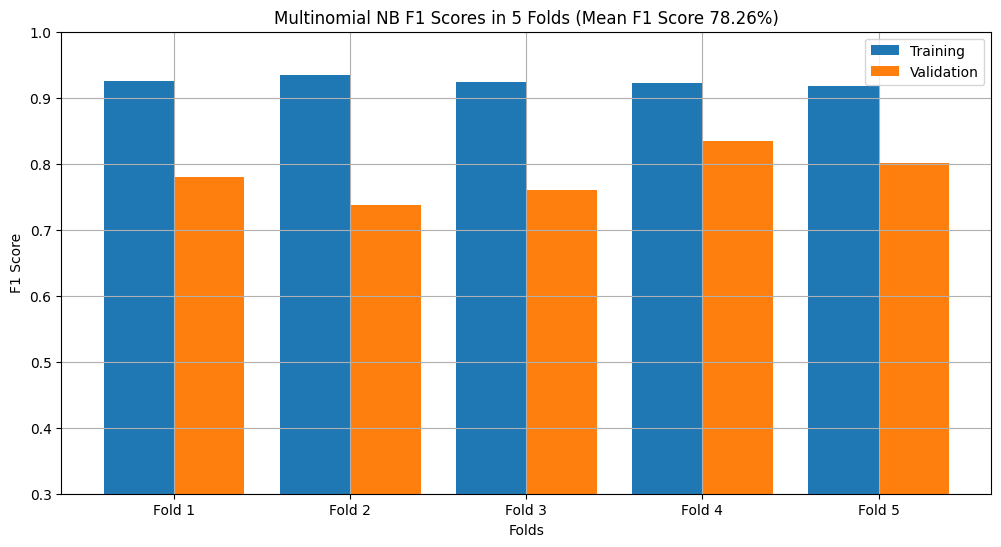

K Nearest Neighbors 

Training Accuracy scores: [0.83581033 0.81316348 0.82743989 0.80410184 0.82390382]
Mean Training Accuracy: 82.0883871826673
Training Precision scores: [0.84507042 0.81607419 0.80979827 0.79320532 0.81669151]
Mean Training Precision: 0.8161679409569645
Training Recall scores: [0.80237741 0.78454681 0.83382789 0.79673591 0.81305638]
Mean Training Recall: 0.8061088795904781
Training F1 scores: [0.82317073 0.8        0.82163743 0.79496669 0.81486989]
Mean Training F1 Score: 0.8109289476846975
Validation Accuracy scores: [0.76836158 0.74011299 0.72804533 0.7733711  0.7223796 ]
Mean Validation Accuracy: 74.64541220531041
Validation Precision scores: [0.75739645 0.75496689 0.69565217 0.75581395 0.71604938]
Mean Validation Precision: 0.7359757694477651
Validation Recall scores: [0.75739645 0.67455621 0.76190476 0.77380952 0.69047619]
Mean Validation Recall: 0.731628627782474
Validation F1 scores: [0.75739645 0.7125     0.72727273 0.76470588 0.7030303 ]
Mean Validation F1 

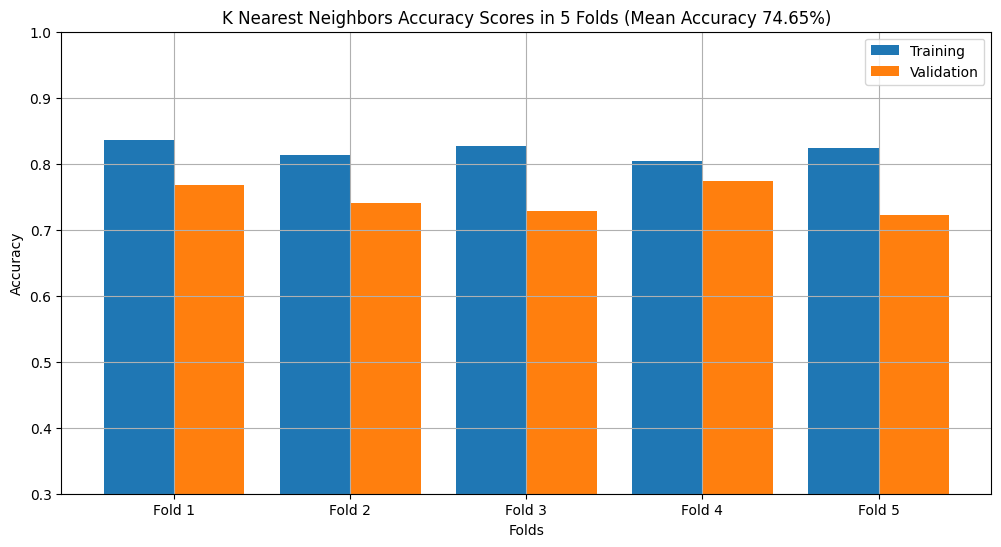

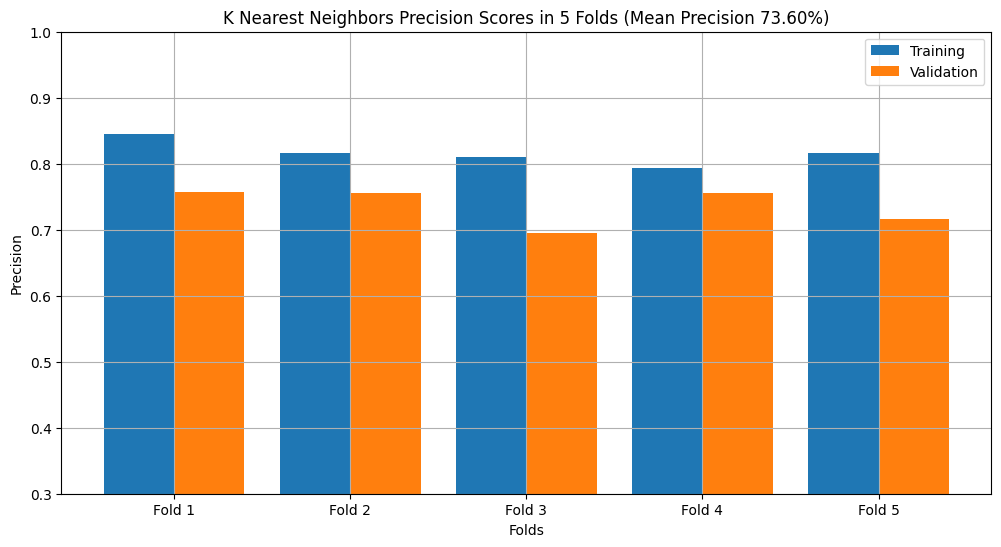

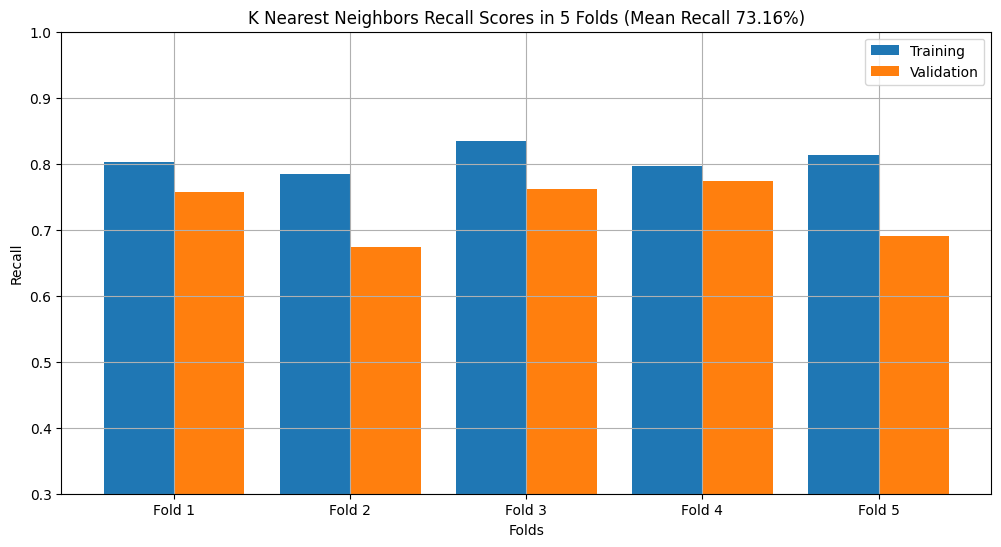

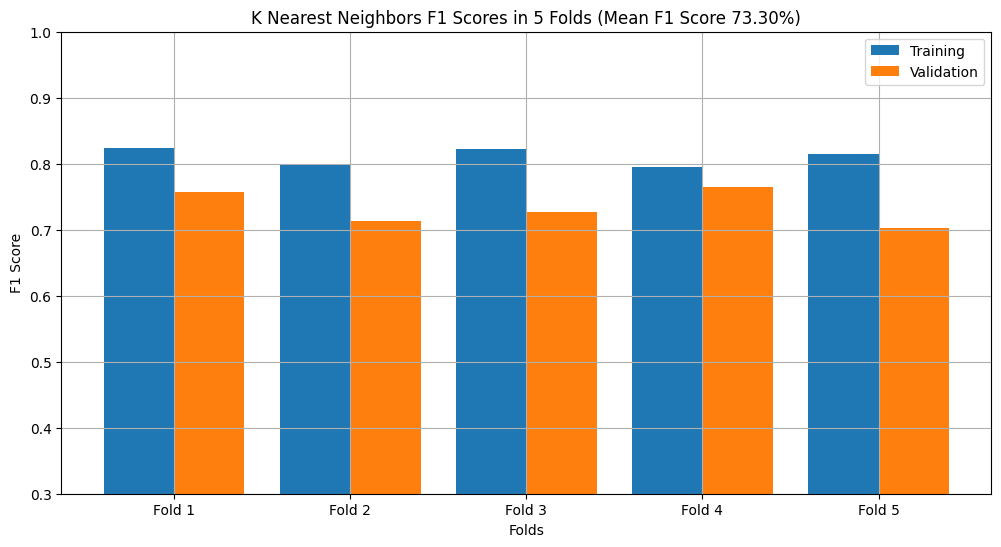

Decision Tree 

Training Accuracy scores: [0.99929229 0.99929229 0.99929279 0.99929279 1.        ]
Mean Training Accuracy: 99.94340289351958
Training Precision scores: [1.         0.99851632 1.         0.99851852 1.        ]
Mean Training Precision: 0.9994069677986591
Training Recall scores: [0.99851412 1.         0.99851632 1.         1.        ]
Mean Training Recall: 0.9994060872747476
Training F1 scores: [0.99925651 0.99925761 0.99925761 0.99925871 1.        ]
Mean Training F1 Score: 0.9994060869474151
Validation Accuracy scores: [0.77683616 0.7259887  0.74787535 0.73937677 0.7733711 ]
Mean Validation Accuracy: 75.26896176437636
Validation Precision scores: [0.77439024 0.74657534 0.73099415 0.7183908  0.77160494]
Mean Validation Precision: 0.7483910962568564
Validation Recall scores: [0.75147929 0.64497041 0.74404762 0.74404762 0.74404762]
Mean Validation Recall: 0.7257185122569738
Validation F1 scores: [0.76276276 0.69206349 0.73746313 0.73099415 0.75757576]
Mean Validation F1 Scor

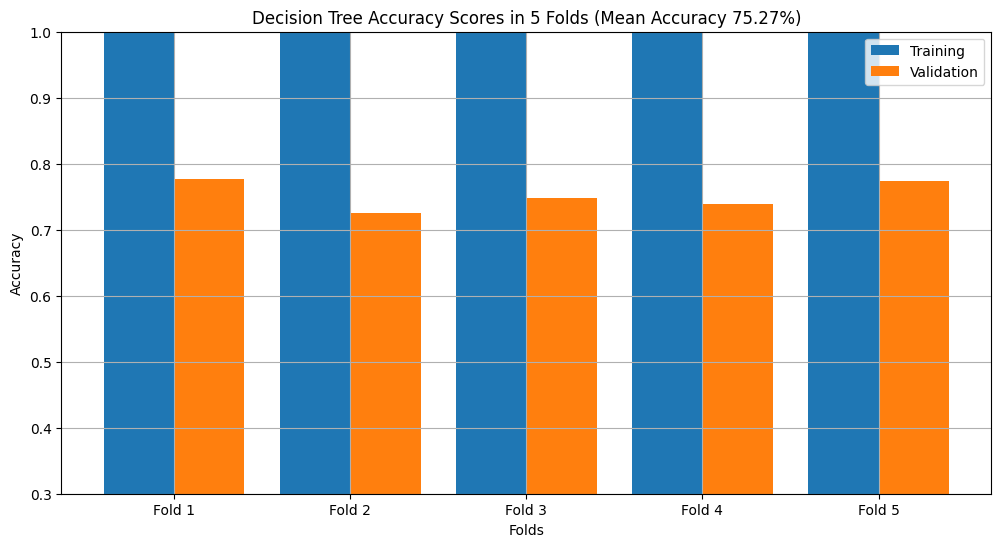

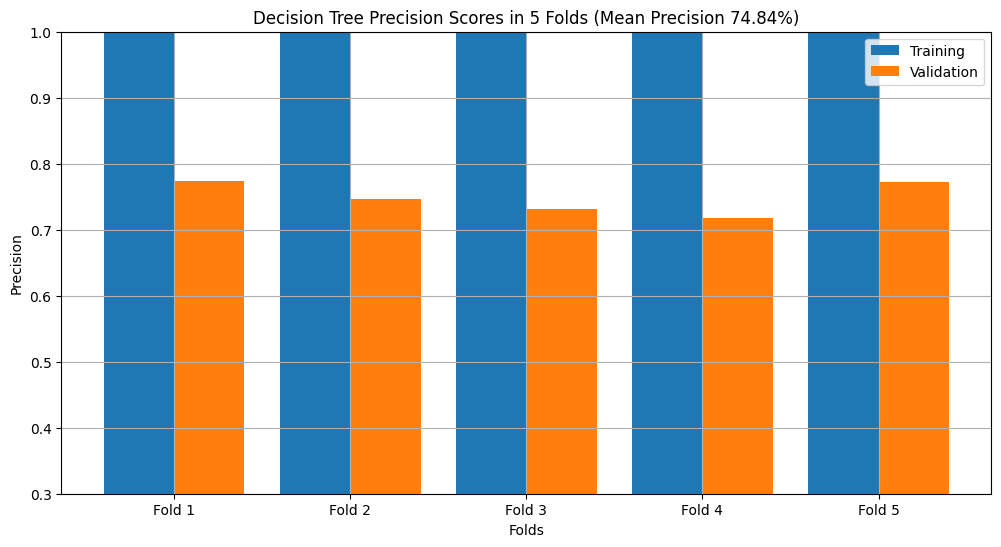

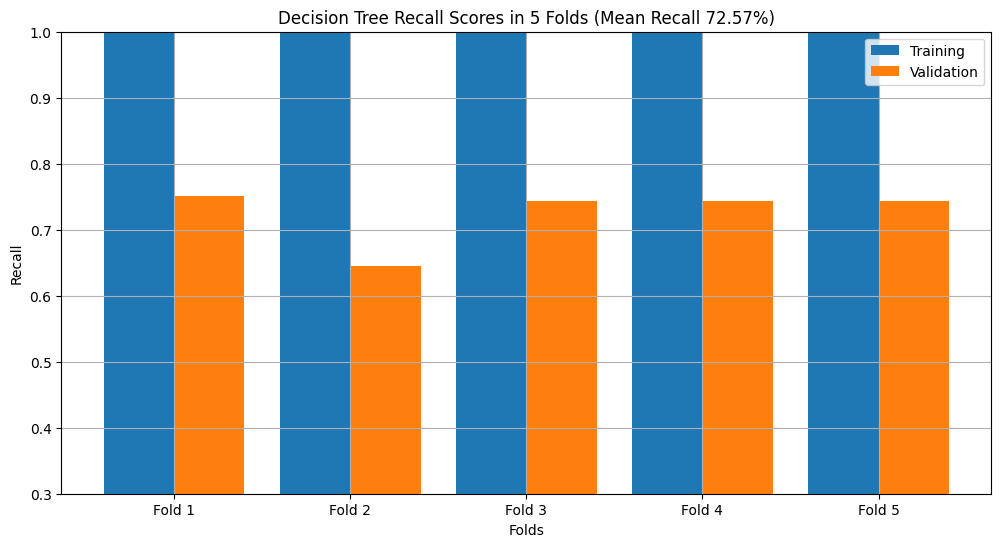

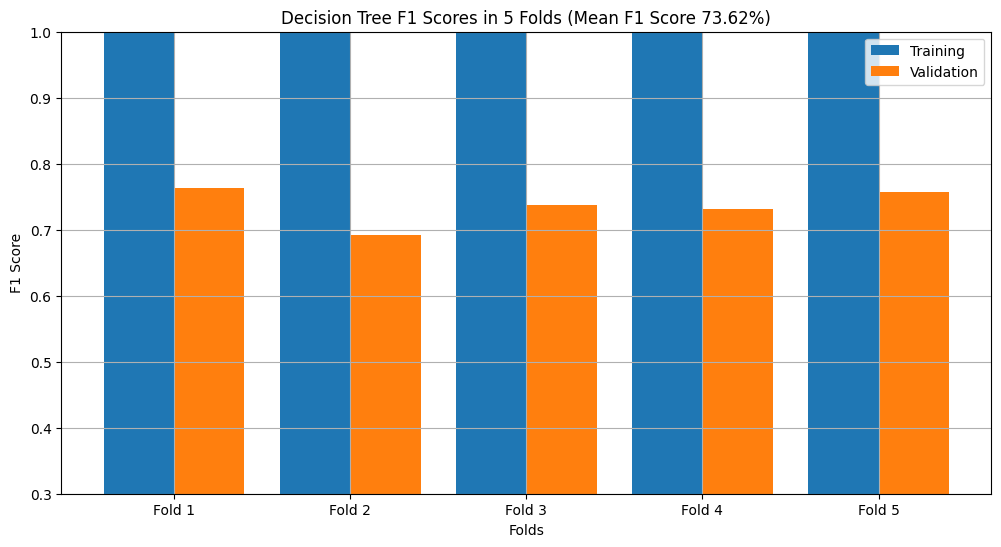

Random Forest 

Training Accuracy scores: [0.99929229 0.99929229 0.99929279 0.99929279 1.        ]
Mean Training Accuracy: 99.94340289351958
Training Precision scores: [0.99851632 0.99851632 0.99851852 0.99851852 1.        ]
Mean Training Precision: 0.9988139355973183
Training Recall scores: [1. 1. 1. 1. 1.]
Mean Training Recall: 1.0
Training F1 scores: [0.99925761 0.99925761 0.99925871 0.99925871 1.        ]
Mean Training F1 Score: 0.9994065278633076
Validation Accuracy scores: [0.79378531 0.74293785 0.77053824 0.80453258 0.76770538]
Mean Validation Accuracy: 77.58998735615627
Validation Precision scores: [0.79268293 0.77083333 0.75739645 0.80745342 0.77922078]
Mean Validation Precision: 0.7815173810473182
Validation Recall scores: [0.76923077 0.65680473 0.76190476 0.77380952 0.71428571]
Mean Validation Recall: 0.735207100591716
Validation F1 scores: [0.78078078 0.70926518 0.75964392 0.79027356 0.74534161]
Mean Validation F1 Score: 0.7570610089102825


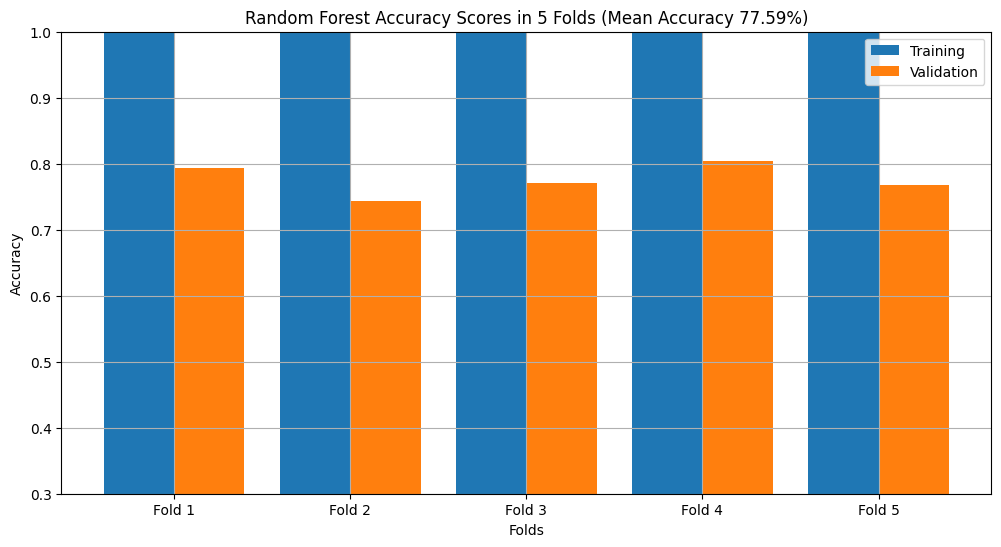

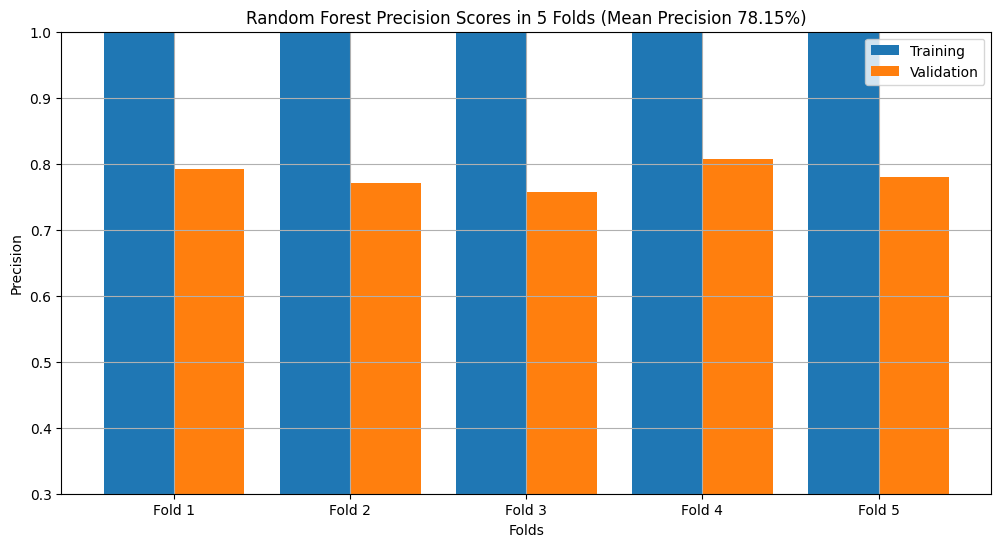

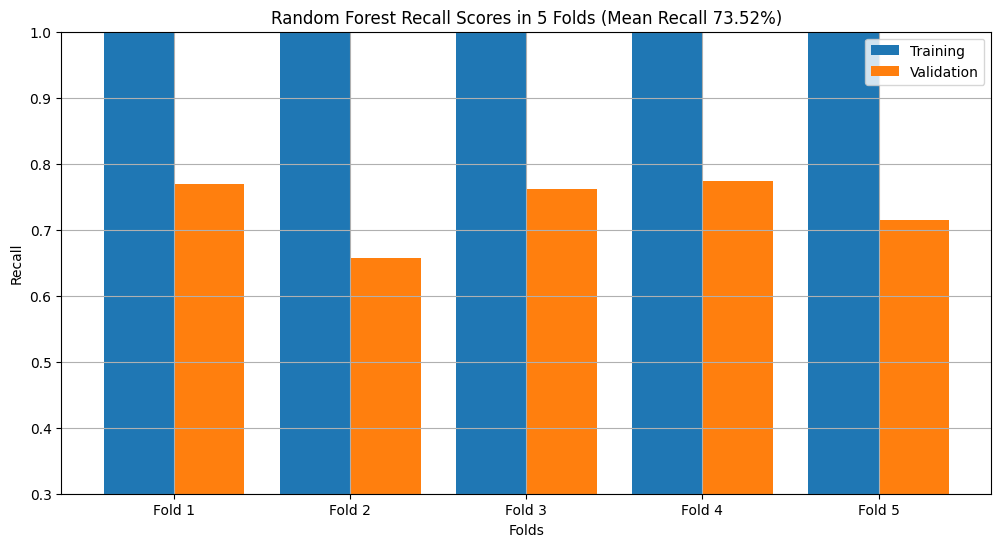

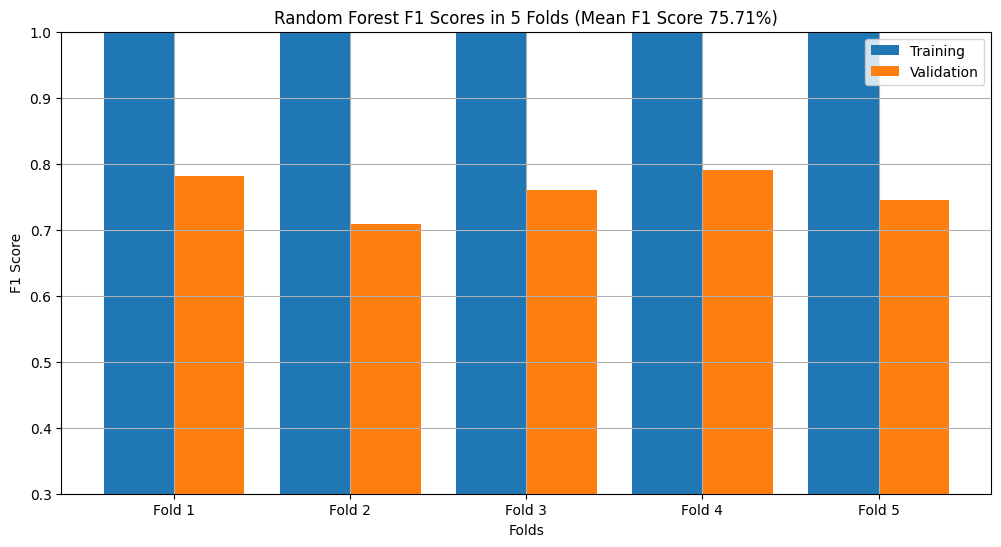

Logistic Regression 

Training Accuracy scores: [0.92073602 0.92993631 0.92008487 0.92362093 0.91725601]
Mean Training Accuracy: 92.2326827769219
Training Precision scores: [0.9375975  0.94565217 0.9375975  0.9367284  0.92780338]
Mean Training Precision: 0.9370757912382732
Training Recall scores: [0.89301634 0.90490342 0.89169139 0.90059347 0.89614243]
Mean Training Recall: 0.8972694123923615
Training F1 scores: [0.91476408 0.92482916 0.91406844 0.9183056  0.91169811]
Mean Training F1 Score: 0.9167330776349301
Validation Accuracy scores: [0.80225989 0.79943503 0.77903683 0.82436261 0.7733711 ]
Mean Validation Accuracy: 79.56930906995727
Validation Precision scores: [0.8        0.83561644 0.75862069 0.83974359 0.78205128]
Mean Validation Precision: 0.8032063999612419
Validation Recall scores: [0.78106509 0.72189349 0.78571429 0.7797619  0.72619048]
Mean Validation Recall: 0.7589250493096646
Validation F1 scores: [0.79041916 0.77460317 0.77192982 0.80864198 0.75308642]
Mean Validation F1

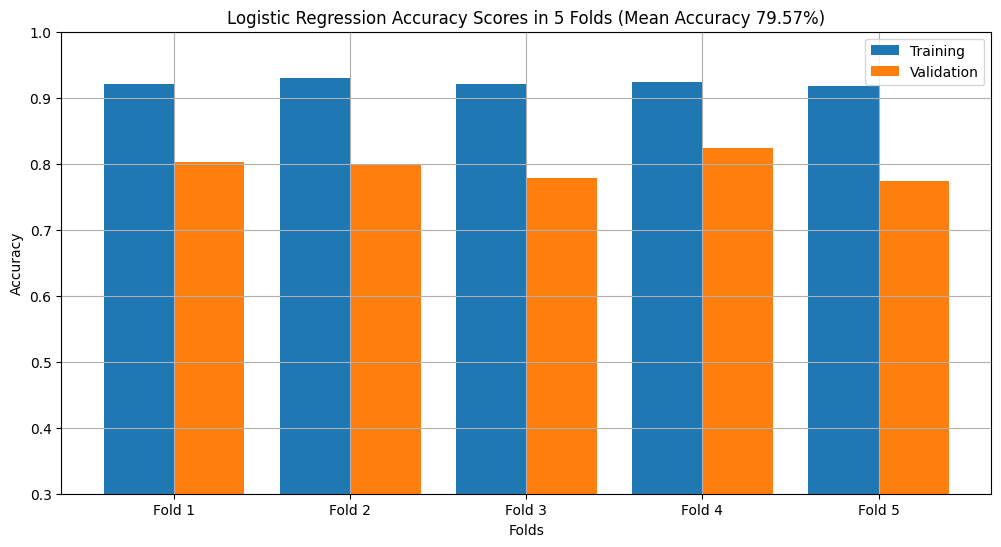

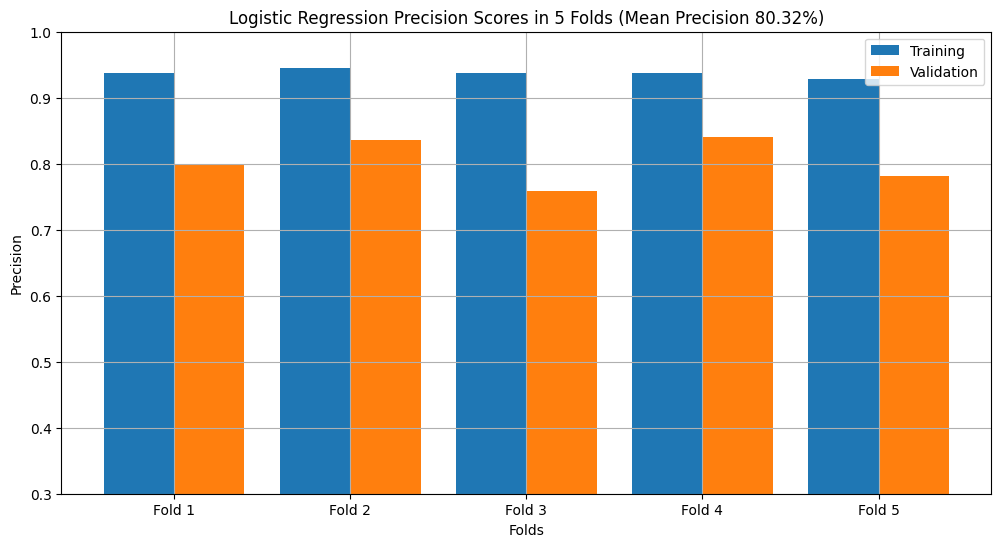

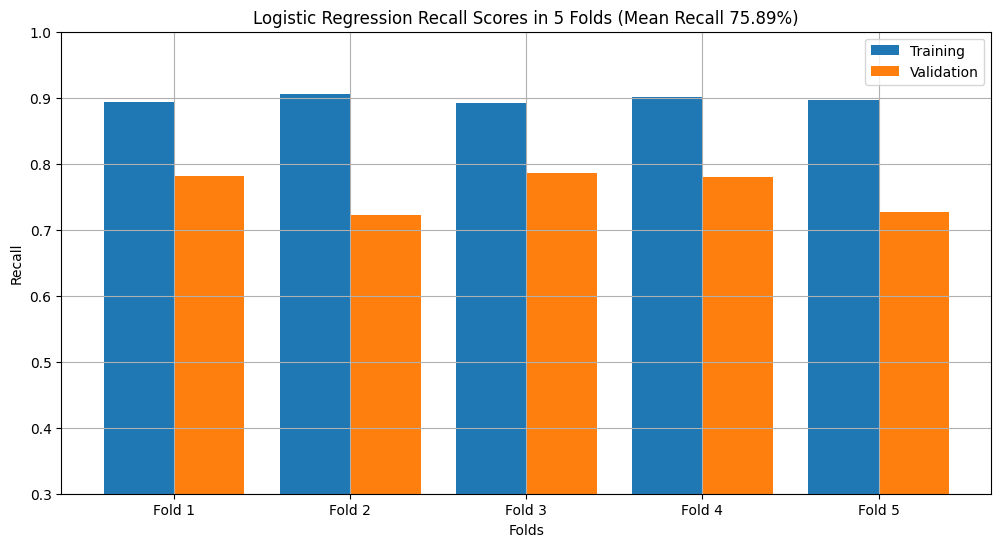

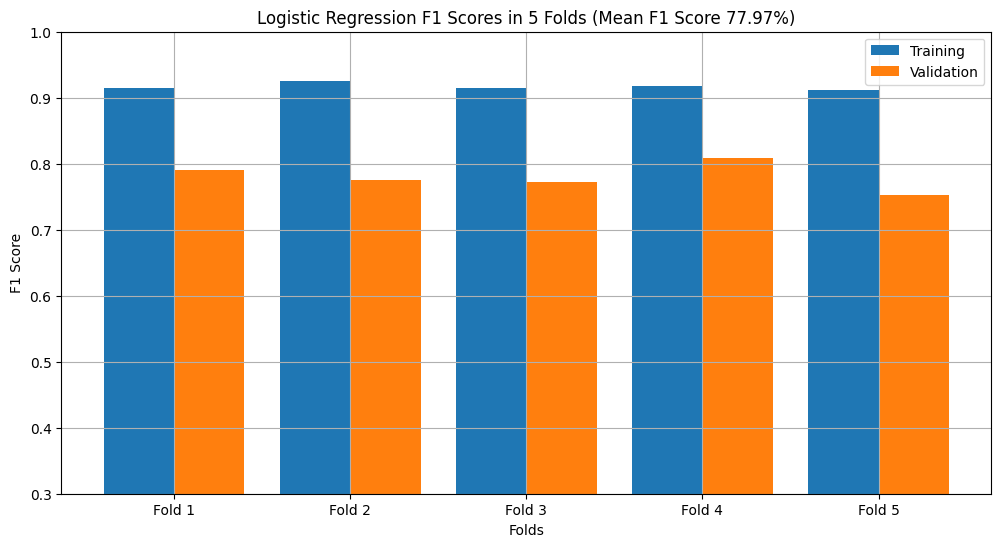

Multilayer Perceptron 

Training Accuracy scores: [0.95116773 0.95612173 0.95120226 0.94625177 0.94554455]
Mean Training Accuracy: 95.00576081265997
Training Precision scores: [0.95209581 0.96217852 0.9455081  0.95718654 0.93576642]
Mean Training Precision: 0.9505470787257126
Training Recall scores: [0.94502229 0.94502229 0.95252226 0.92878338 0.95103858]
Mean Training Recall: 0.9444777580345765
Training F1 scores: [0.94854586 0.95352324 0.94900222 0.94277108 0.94334069]
Mean Training F1 Score: 0.9474366185991322
Validation Accuracy scores: [0.83615819 0.82485876 0.78186969 0.8611898  0.8101983 ]
Mean Validation Accuracy: 82.2854947904163
Validation Precision scores: [0.83233533 0.87412587 0.74594595 0.9047619  0.77900552]
Mean Validation Precision: 0.8272349158073841
Validation Recall scores: [0.82248521 0.73964497 0.82142857 0.79166667 0.83928571]
Mean Validation Recall: 0.802902225979149
Validation F1 scores: [0.82738095 0.80128205 0.78186969 0.84444444 0.80802292]
Mean Validation F

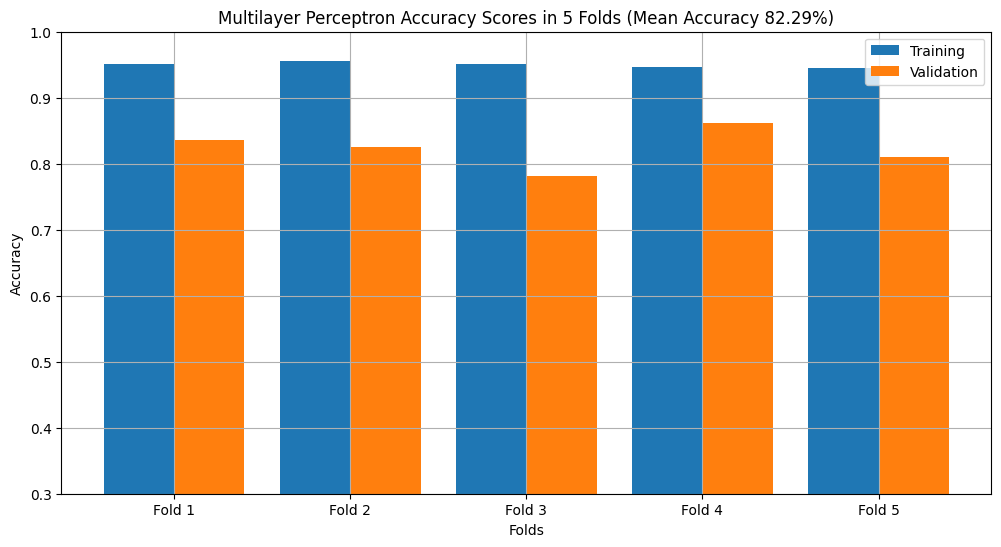

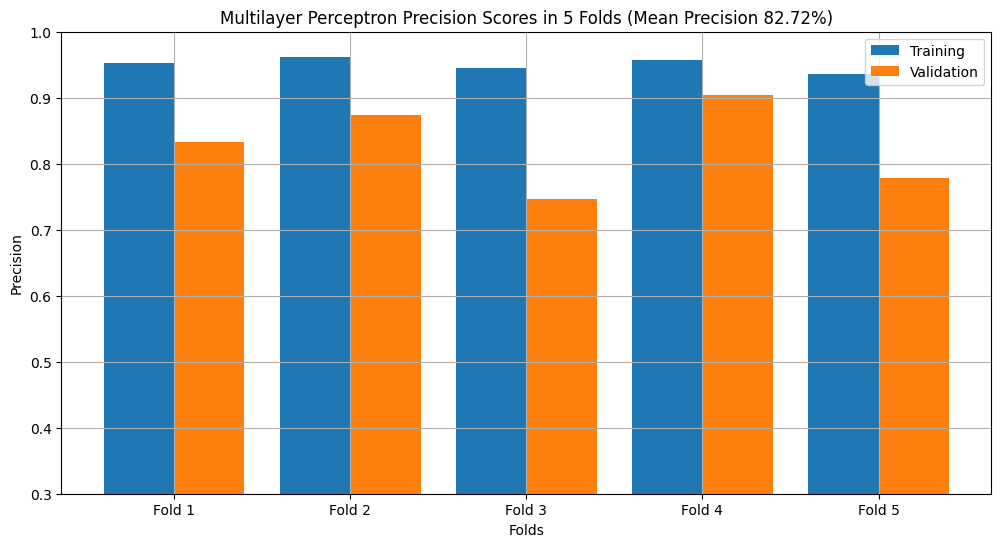

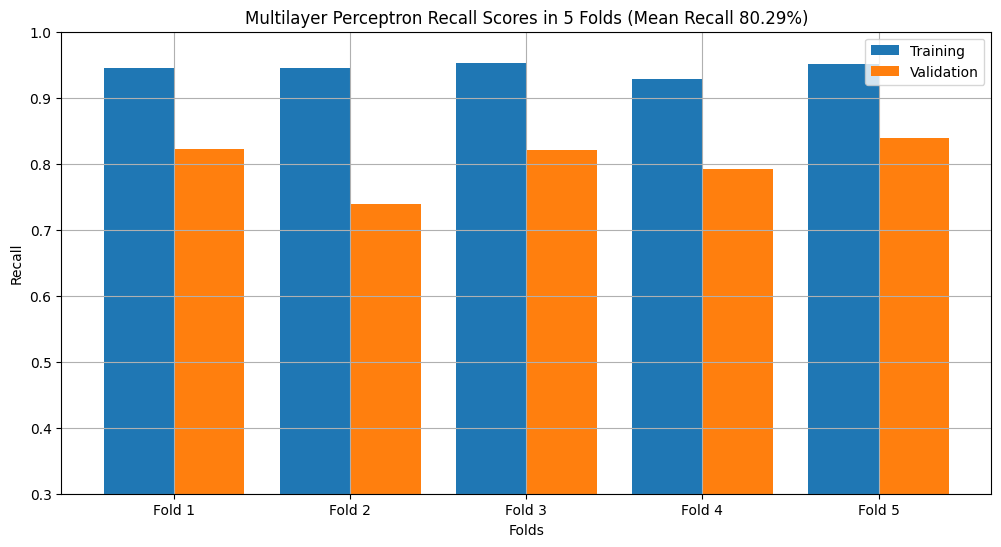

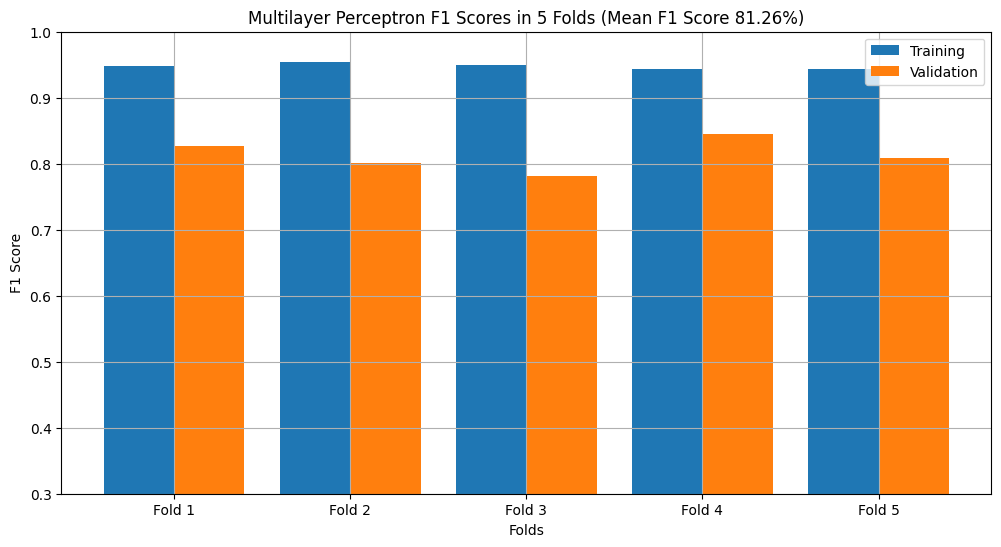

In [92]:
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

def cross_validation(model, train_x, train_y, cv=5):
    scoring = ['accuracy', 'precision', 'recall', 'f1']
    results = cross_validate(
        estimator=model,
        X=train_x,
        y=train_y,
        cv=cv,
        scoring=scoring,
        return_train_score=True
    )
      
    training_result = {
        "Training Accuracy scores": results['train_accuracy'],
        "Mean Training Accuracy": results['train_accuracy'].mean()*100,
        "Training Precision scores": results['train_precision'],
        "Mean Training Precision": results['train_precision'].mean(),
        "Training Recall scores": results['train_recall'],
        "Mean Training Recall": results['train_recall'].mean(),
        "Training F1 scores": results['train_f1'],
        "Mean Training F1 Score": results['train_f1'].mean(),
        "Validation Accuracy scores": results['test_accuracy'],
        "Mean Validation Accuracy": results['test_accuracy'].mean()*100,
        "Validation Precision scores": results['test_precision'],
        "Mean Validation Precision": results['test_precision'].mean(),
        "Validation Recall scores": results['test_recall'],
        "Mean Validation Recall": results['test_recall'].mean(),
        "Validation F1 scores": results['test_f1'],
        "Mean Validation F1 Score": results['test_f1'].mean()
    }

    return training_result

def plot_result(model_name, ylabel, desc, training_data, validation_data, mean_data):
    plt.figure(figsize=(12,6))

    labels = ["Fold 1", "Fold 2", "Fold 3", "Fold 4", "Fold 5"]
    x_axis = np.arange(len(labels))

    ax = plt.gca()

    plt.bar(x_axis - 0.2, training_data, 0.4, label='Training')
    plt.bar(x_axis + 0.2, validation_data, 0.4, label='Validation')
    
    plt.ylim(0.3, 1)
    plt.title(F"{model_name} {desc} (Mean {ylabel} {mean_data:.2%})")
    plt.xticks(x_axis, labels)
    plt.xlabel("Folds")
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend()
    
    plt.show()

random.shuffle(training_dataset)

feature_list = [tup[0] for tup in training_dataset]
x = []
for dictionary in feature_list:
    values = [*dictionary.values()]
    x.append(values)

y = [tup[1] for tup in training_dataset]
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(y)

models = {
    "Multinomial NB": MultinomialNB(),
    "K Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Logistic Regression": LogisticRegression(),
    "Multilayer Perceptron": MLPClassifier(max_iter=1000),
}

for model_name, model in models.items():
    model_training_result = cross_validation(model, x, encoded_y, 5)

    print(model_name, "\n")
    for key in model_training_result:
        value = model_training_result[key]
        print(F"{key}: {value}")

    plot_result(
        model_name,
        "Accuracy",
        "Accuracy Scores in 5 Folds",
        model_training_result["Training Accuracy scores"],
        model_training_result["Validation Accuracy scores"],
        model_training_result["Mean Validation Accuracy"]/100
    )

    plot_result(
        model_name,
        "Precision",
        "Precision Scores in 5 Folds",
        model_training_result["Training Precision scores"],
        model_training_result["Validation Precision scores"],
        model_training_result["Mean Validation Precision"]
    )

    plot_result(
        model_name,
        "Recall",
        "Recall Scores in 5 Folds",
        model_training_result["Training Recall scores"],
        model_training_result["Validation Recall scores"],
        model_training_result["Mean Validation Recall"]
    )

    plot_result(
        model_name,
        "F1 Score",
        "F1 Scores in 5 Folds",
        model_training_result["Training F1 scores"],
        model_training_result["Validation F1 scores"],
        model_training_result["Mean Validation F1 Score"]
    )

Support Vector Machine 

Training Accuracy scores: [0.88181175 0.90021231 0.88330976 0.90028289 0.88613861]
Mean Training Accuracy: 89.03510642238018
Training Precision scores: [0.92307692 0.92765273 0.9234609  0.93760263 0.92396694]
Mean Training Precision: 0.9271520248209899
Training Recall scores: [0.82020802 0.85735513 0.82344214 0.84718101 0.82937685]
Mean Training Recall: 0.8355126300148588
Training F1 scores: [0.8686074  0.89111969 0.87058824 0.89010133 0.87412041]
Mean Training F1 Score: 0.8789074107504604
Validation Accuracy scores: [0.79096045 0.75423729 0.77620397 0.80453258 0.7733711 ]
Mean Validation Accuracy: 77.98610777676413
Validation Precision scores: [0.84172662 0.79285714 0.81118881 0.82781457 0.83333333]
Mean Validation Precision: 0.8213840951241493
Validation Recall scores: [0.69230769 0.65680473 0.69047619 0.74404762 0.6547619 ]
Mean Validation Recall: 0.6876796280642434
Validation F1 scores: [0.75974026 0.7184466  0.74598071 0.78369906 0.73333333]
Mean Validatio

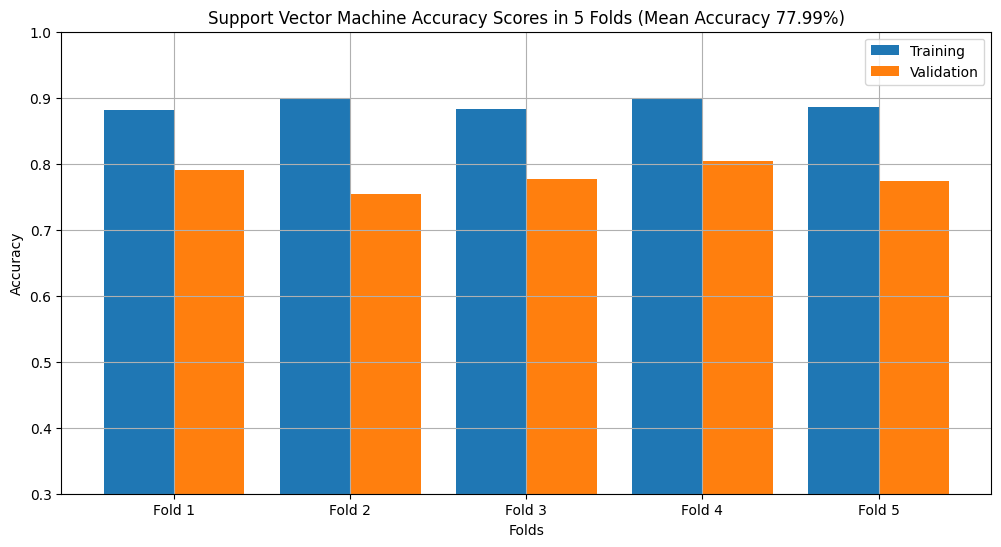

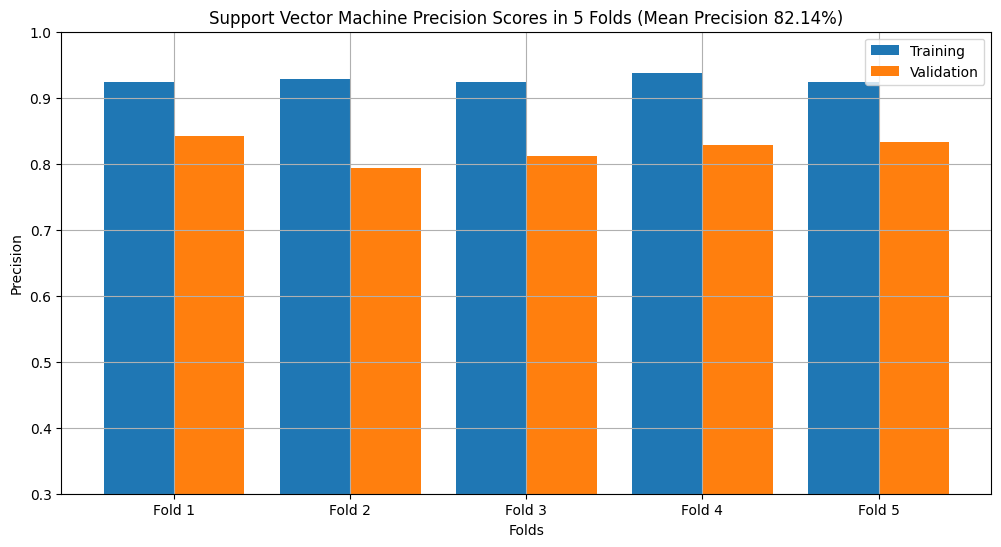

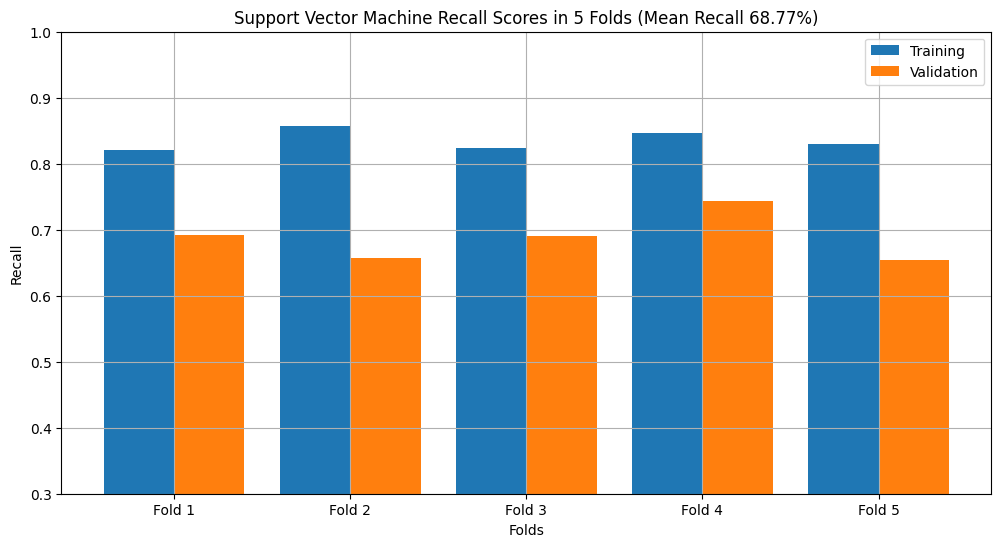

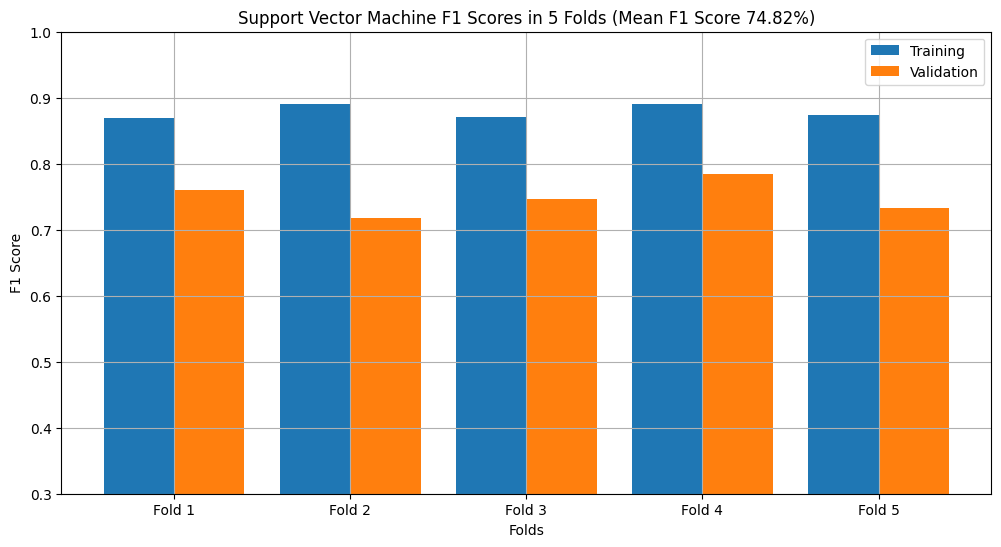

In [3]:
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

def cross_validation(model, train_x, train_y, cv=5):
    scoring = ['accuracy', 'precision', 'recall', 'f1']
    results = cross_validate(
        estimator=model,
        X=train_x,
        y=train_y,
        cv=cv,
        scoring=scoring,
        return_train_score=True
    )
      
    training_result = {
        "Training Accuracy scores": results['train_accuracy'],
        "Mean Training Accuracy": results['train_accuracy'].mean()*100,
        "Training Precision scores": results['train_precision'],
        "Mean Training Precision": results['train_precision'].mean(),
        "Training Recall scores": results['train_recall'],
        "Mean Training Recall": results['train_recall'].mean(),
        "Training F1 scores": results['train_f1'],
        "Mean Training F1 Score": results['train_f1'].mean(),
        "Validation Accuracy scores": results['test_accuracy'],
        "Mean Validation Accuracy": results['test_accuracy'].mean()*100,
        "Validation Precision scores": results['test_precision'],
        "Mean Validation Precision": results['test_precision'].mean(),
        "Validation Recall scores": results['test_recall'],
        "Mean Validation Recall": results['test_recall'].mean(),
        "Validation F1 scores": results['test_f1'],
        "Mean Validation F1 Score": results['test_f1'].mean()
    }

    return training_result

def plot_result(model_name, ylabel, desc, training_data, validation_data, mean_data):
    plt.figure(figsize=(12,6))

    labels = ["Fold 1", "Fold 2", "Fold 3", "Fold 4", "Fold 5"]
    x_axis = np.arange(len(labels))

    ax = plt.gca()

    plt.bar(x_axis - 0.2, training_data, 0.4, label='Training')
    plt.bar(x_axis + 0.2, validation_data, 0.4, label='Validation')
    
    plt.ylim(0.3, 1)
    plt.title(F"{model_name} {desc} (Mean {ylabel} {mean_data:.2%})")
    plt.xticks(x_axis, labels)
    plt.xlabel("Folds")
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend()
    
    plt.show()

random.shuffle(training_dataset)

feature_list = [tup[0] for tup in training_dataset]
x = []
for dictionary in feature_list:
    values = [*dictionary.values()]
    x.append(values)

y = [tup[1] for tup in training_dataset]
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(y)

model = SVC()
model_name = "Support Vector Machine"

model_training_result = cross_validation(model, x, encoded_y, 5)

print(model_name, "\n")
for key in model_training_result:
    value = model_training_result[key]
    print(F"{key}: {value}")

plot_result(
    model_name,
    "Accuracy",
    "Accuracy Scores in 5 Folds",
    model_training_result["Training Accuracy scores"],
    model_training_result["Validation Accuracy scores"],
    model_training_result["Mean Validation Accuracy"]/100
)

plot_result(
    model_name,
    "Precision",
    "Precision Scores in 5 Folds",
    model_training_result["Training Precision scores"],
    model_training_result["Validation Precision scores"],
    model_training_result["Mean Validation Precision"]
)

plot_result(
    model_name,
    "Recall",
    "Recall Scores in 5 Folds",
    model_training_result["Training Recall scores"],
    model_training_result["Validation Recall scores"],
    model_training_result["Mean Validation Recall"]
)

plot_result(
    model_name,
    "F1 Score",
    "F1 Scores in 5 Folds",
    model_training_result["Training F1 scores"],
    model_training_result["Validation F1 scores"],
    model_training_result["Mean Validation F1 Score"]
)

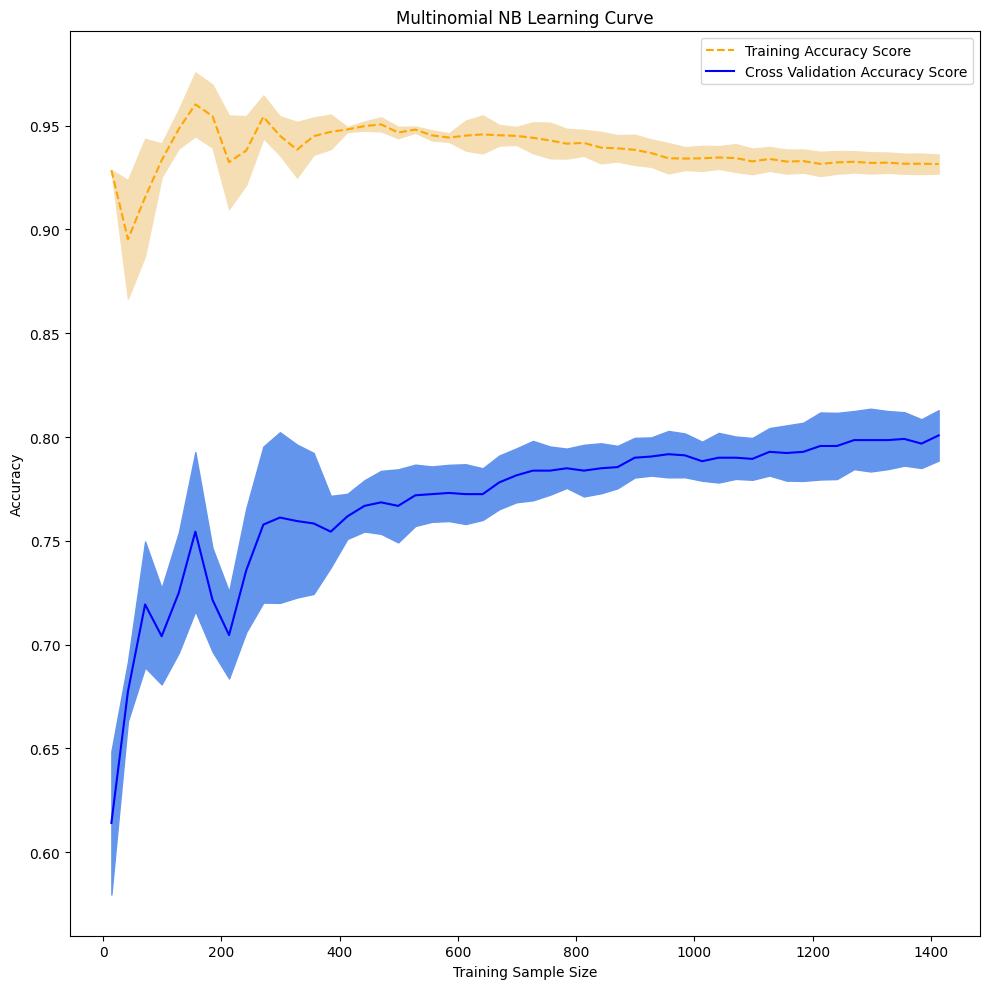

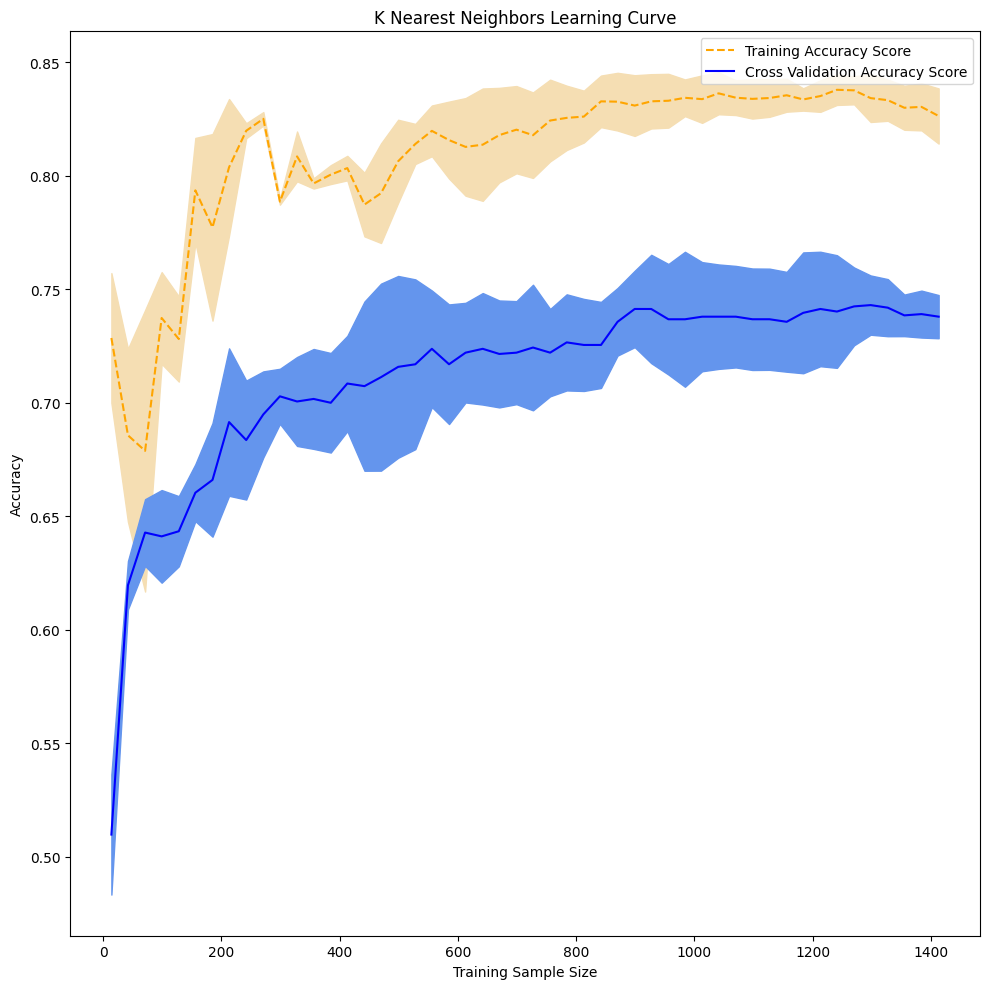

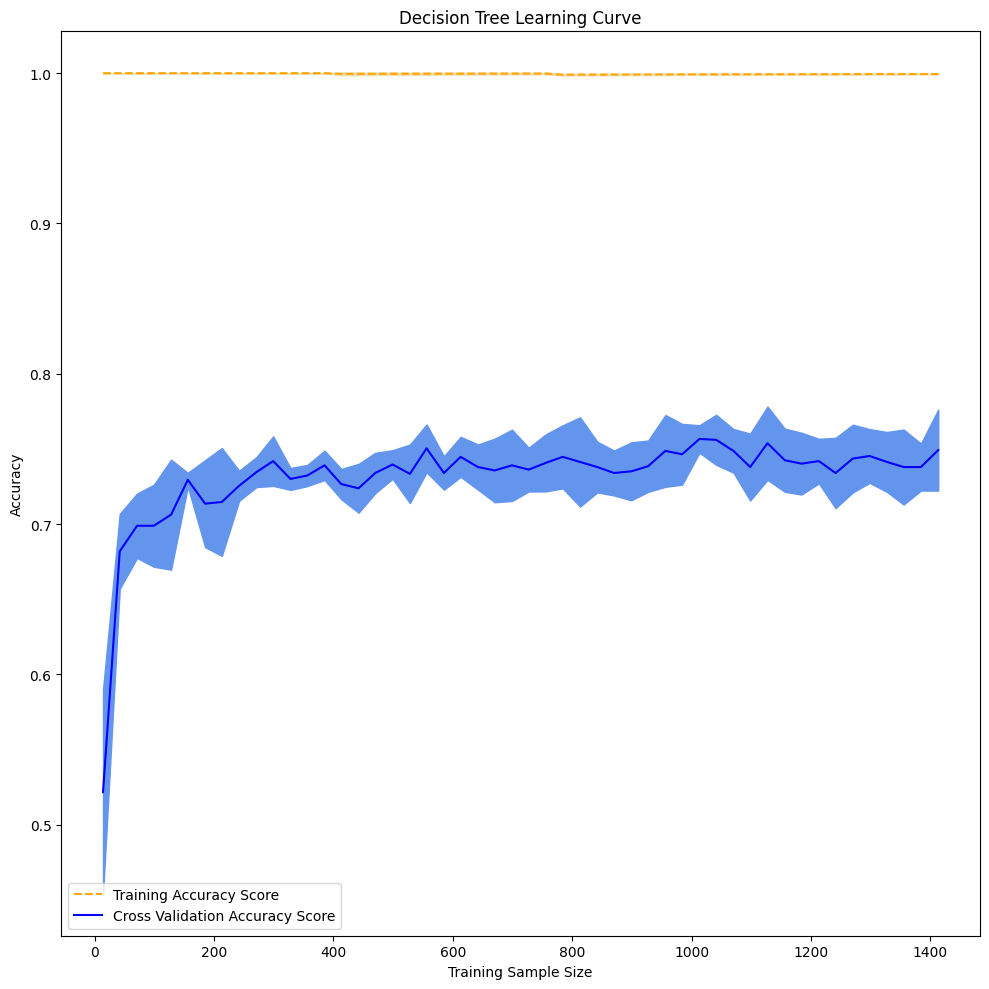

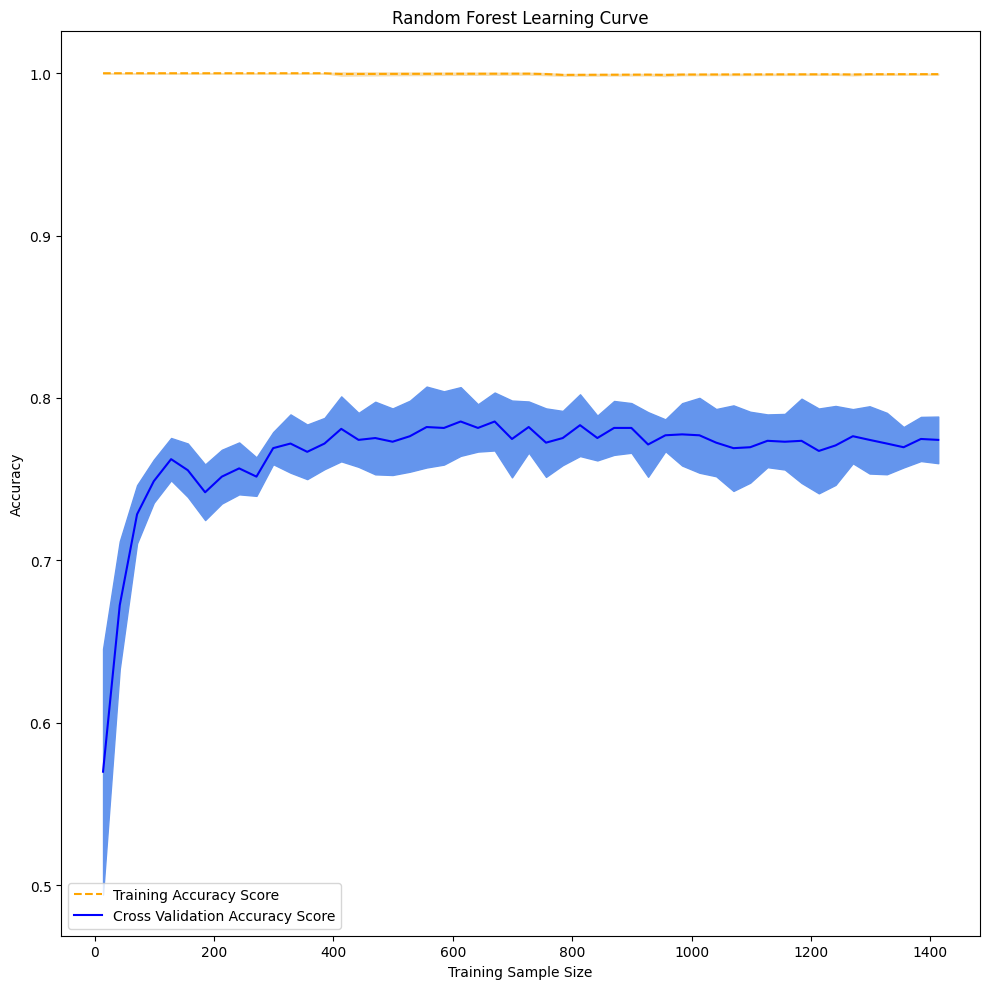

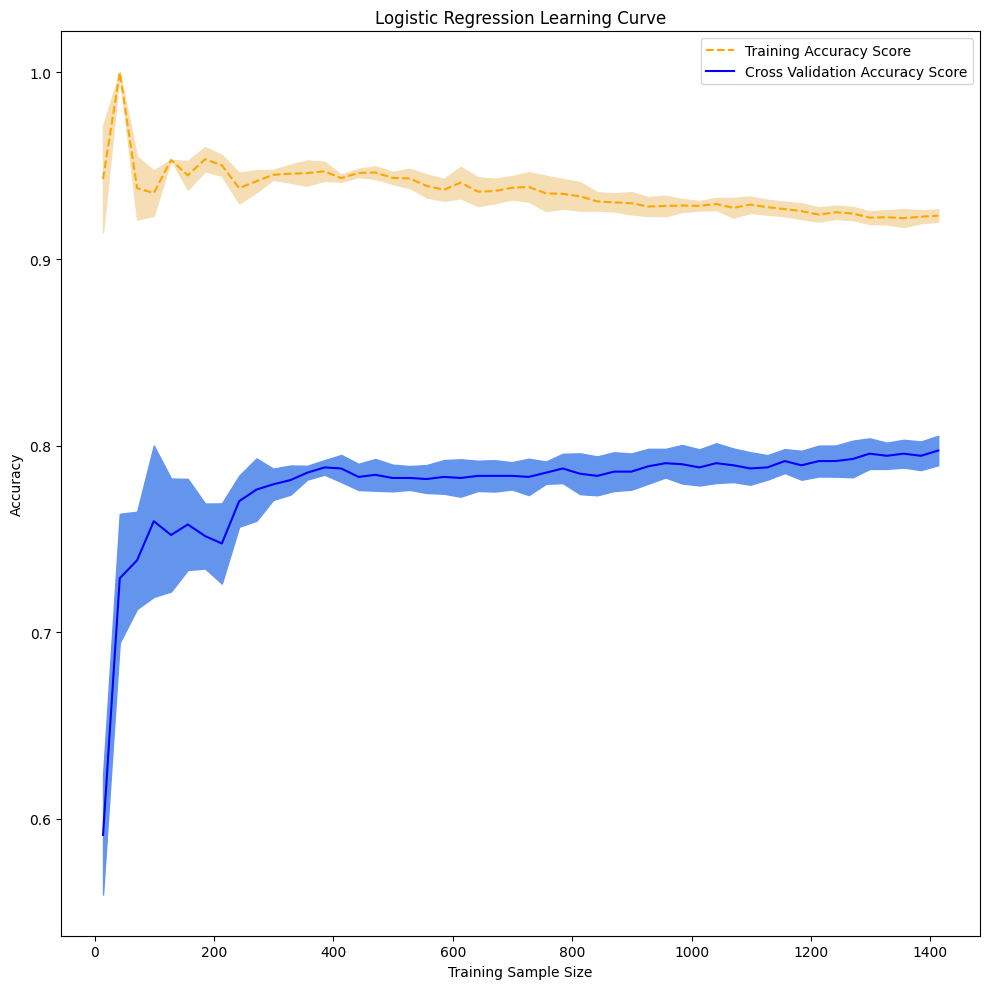

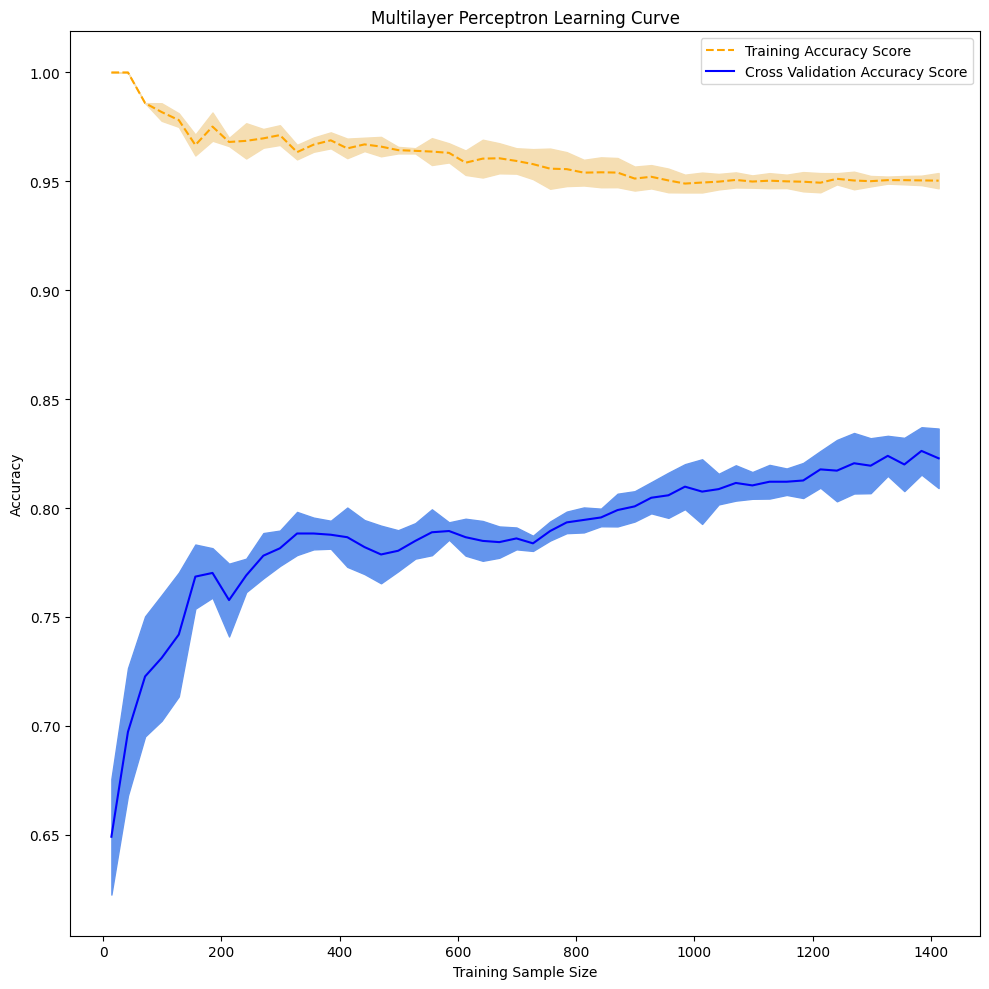

In [93]:
from sklearn.model_selection import learning_curve

random.shuffle(training_dataset)

feature_list = [tup[0] for tup in training_dataset]
x = []
for dictionary in feature_list:
    values = [*dictionary.values()]
    x.append(values)

y = [tup[1] for tup in training_dataset]

label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(y)

models = {
    "Multinomial NB": MultinomialNB(),
    "K Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Logistic Regression": LogisticRegression(),
    "Multilayer Perceptron": MLPClassifier(max_iter=1000),
    
}

for model_name, model in models.items():
    train_sizes, train_scores, test_scores = learning_curve(model, x, y, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50))

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.subplots(1, figsize=(10,10))
    plt.plot(train_sizes, train_mean, '--', color='orange',  label='Training Accuracy Score')
    plt.plot(train_sizes, test_mean, color='blue', label='Cross Validation Accuracy Score')

    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='wheat')
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='cornflowerblue')

    plt.title(F"{model_name} Learning Curve")
    plt.xlabel("Training Sample Size")
    plt.ylabel("Accuracy")
    plt.legend(loc="best")
    plt.tight_layout()

    plt.show()

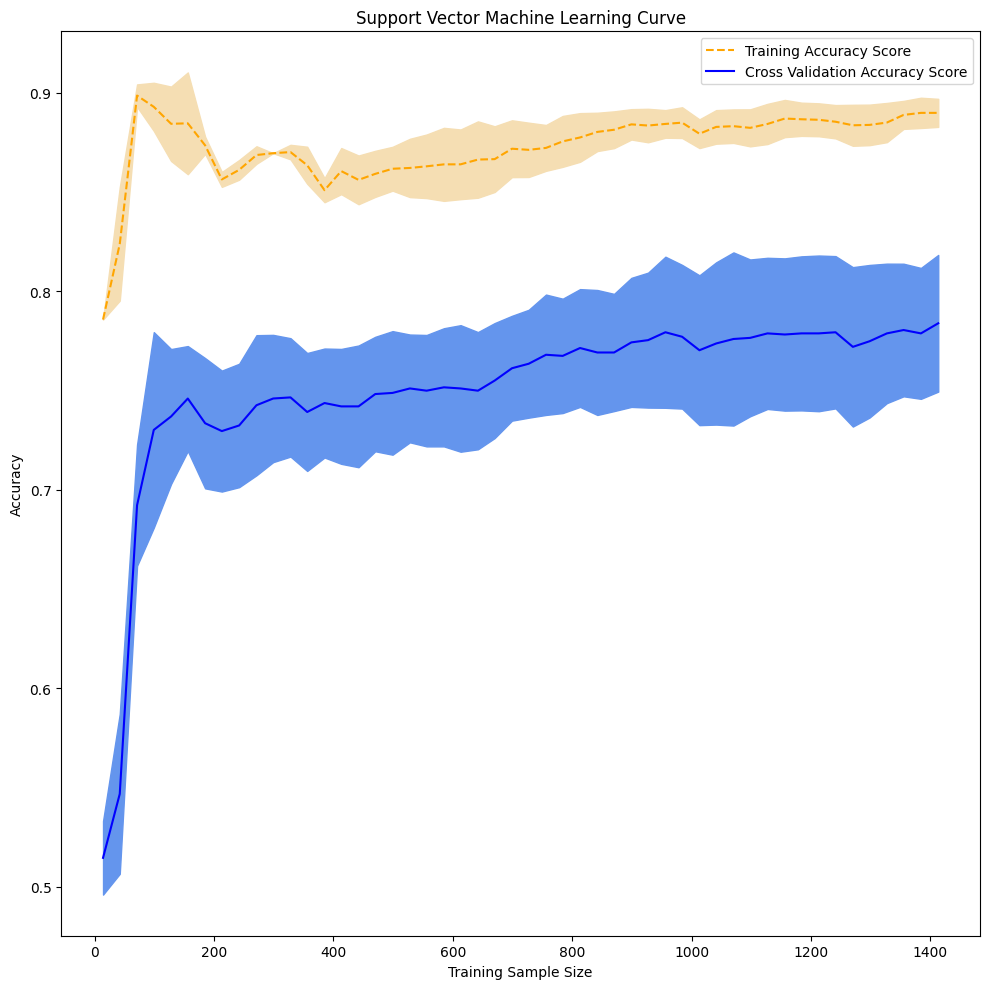

In [4]:
from sklearn.model_selection import learning_curve

random.shuffle(training_dataset)

feature_list = [tup[0] for tup in training_dataset]
x = []
for dictionary in feature_list:
    values = [*dictionary.values()]
    x.append(values)

y = [tup[1] for tup in training_dataset]

label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(y)

model = SVC()
model_name = "Support Vector Machine"

train_sizes, train_scores, test_scores = learning_curve(model, x, y, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50))

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.subplots(1, figsize=(10,10))
plt.plot(train_sizes, train_mean, '--', color='orange',  label='Training Accuracy Score')
plt.plot(train_sizes, test_mean, color='blue', label='Cross Validation Accuracy Score')

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='wheat')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='cornflowerblue')

plt.title(F"{model_name} Learning Curve")
plt.xlabel("Training Sample Size")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.tight_layout()

plt.show()

In [ ]:
feature_list = [tup[0] for tup in training_dataset]
x = []
for dictionary in feature_list:
    values = [*dictionary.values()]
    x.append(values)

y = [tup[1] for tup in training_dataset]

label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(y)

model.fit(x, encoded_y)

new_tweets = [""]

features = [get_features(new_tweet) for new_tweet in new_tweets]
x = []
for dictionary in features:
    values = [*dictionary.values()]
    x.append(values)
x = np.array(x)

model.predict(x)
